# Retrieval模块的设计意义

Retrieval直接翻译过来即“检索”，本章Retrieval模块包括与检索步骤相关的所有内容，例如数据的获取、切分、向量化、向量存储、向量检索等模块。常被应用于构建一个“ 企业/私人的知识库 ”，提升大
模型的整体能力。

## 大模型的幻觉问题
拥有记忆后，确实扩展了AI工程的应用场景。但是在专有领域，LLM无法学习到所有的专业知识细节，因此在 面向专业领域知识 的提问时，无法给出可靠准确的回答，甚至会“胡言乱语”，这种现象称之为 LLM的“幻觉” 。

大模型生成内容的不可控，尤其是在金融和医疗领域等领域，一次金额评估的错误，一次医疗诊断的失误，哪怕只出现一次都是致命的。但，对于非专业人士来说可能难以辨识。目前还没有能够百分之百解决这种情况的方案。

**当前大家普遍达成共识的一个方案：**

首先，为大模型提供一定的上下文信息，让其输出会变得更稳定。

其次，利用本章的RAG，将检索出来的 文档和提示词 输送给大模型，生成更可靠的答案。

## RAG的解决方案
可以说，当应用需求集中在利用大模型去 回答特定私有领域的知识 ，且知识库足够大，那么除了 微调大模型 外， RAG 就是非常有效的一种缓解大模型推理的“幻觉”问题的解决方案。

LangChain对这一流程提供了解决方案。
> 如果说LangChain相当于给LLM这个“⼤脑”安装了“四肢和躯⼲”，RAG则是为LLM提供了接
⼊“⼈类知识图书馆”的能⼒。

## RAG的优缺点
**优点：**
* 相比提示词工程，RAG有 更丰富的上下文和数据样本 ，可以不需要用户提供过多的背景描述，就能生成比较符合用户预期的答案。
* 相比于模型微调，RAG可以提升问答内容的 **时效性** 和 **可靠性**
* 在一定程度上保护了业务数据的 隐私性 。

**缺点：**
* 由于每次问答都涉及外部系统数据检索，因此RAG的 响应时延 相对较高。
* 引用的外部知识数据会 消耗大量的模型Token 资源

## Retrieval流程
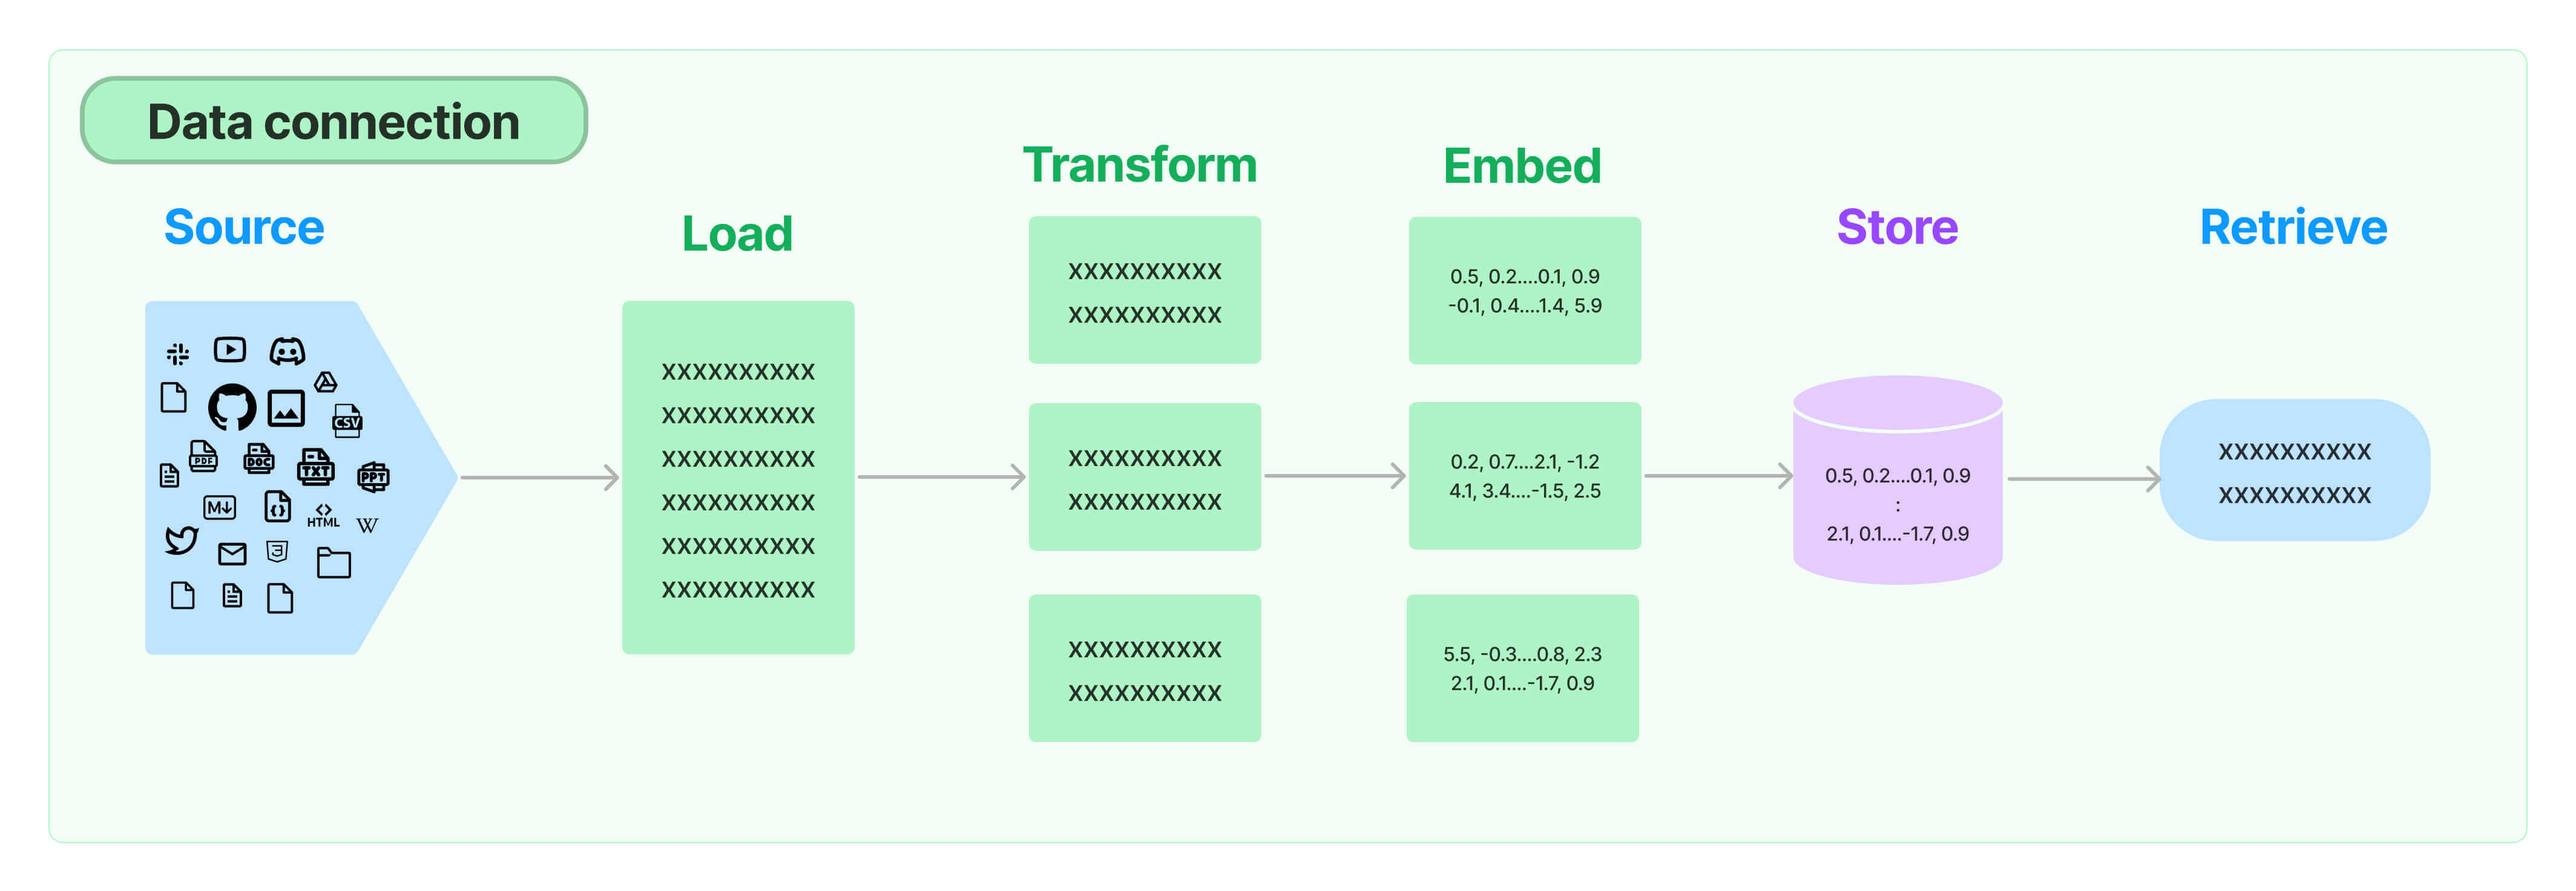

### 环节1：Source（数据源）
指的是RAG架构中所外挂的知识库。这里有三点说明：
1. 原始数据源类型多样：如：视频、图片、文本、代码、文档等
2. 形式的多样性：

    可以是上百个.csv文件，可以是上千个.json文件，也可以是上万个.pdf文件

    可以是某一个业务流程外放的API，可以是某个网站的实时数据等
### 环节2：Load（加载）
文档加载器（Document Loaders）负责将来自不同数据源的非结构化文本，加载到内存，成为文档(Document)对象。

文档对象包含文档内容和相关元数据信息，例如TXT、CSV、HTML、JSON、Markdown、PDF，甚至YouTube 视频转录等。

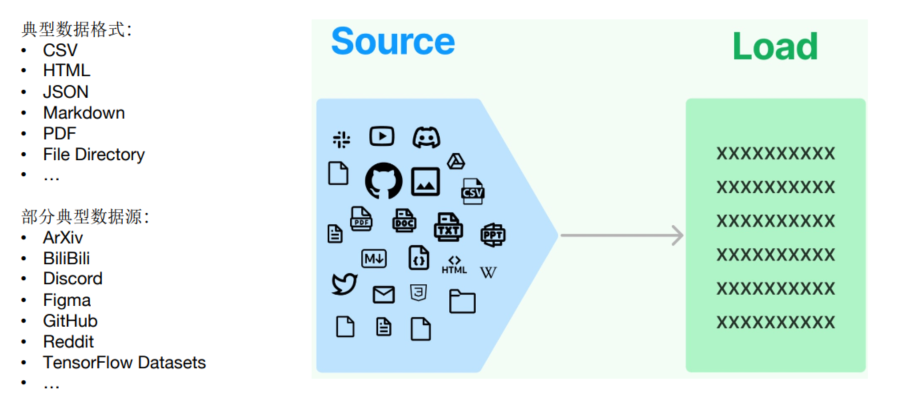

文档加载器还支持“ 延迟加载”模式，以缓解处理大文件时的内存压力。

文档加载器的编程接口使用起来非常简单，以下给出加载TXT格式文档的例子。

```python
from langchain.document_loadersimport TextLoader
text_loader = TextLoader("./test.txt")
docs = text_loader.load() # 返回List列表(Document对象)
print(docs)
```
### 环节3：Transform（转换）
文档转换器(Document Transformers) 负责对加载的文档进行转换和处理，以便更好地适应下游任务的需求。

文档转换器提供了一致的接口（工具）来操作文档，主要包括以下几类：
* 文本拆分器(Text Splitters) ：将长文本拆分成语义上相关的小块，以适应语言模型的上下文窗口限制。
* 冗余过滤器(Redundancy Filters) ：识别并过滤重复的文档。
* 元数据提取器(Metadata Extractors) ：从文档中提取标题、语调等结构化元数据。
* 多语言转换器(Multi-lingual Transformers) ：实现文档的机器翻译。
* 对话转换器(Conversational Transformers) ：将非结构化对话转换为问答格式的文档。

总的来说，文档转换器是 LangChain 处理管道中非常重要的一个组件，它丰富了框架对文档的表示和操作能力。

而在这些功能中，文档拆分器是必须的操作。下面单独说明：

**Text Splitting（文档拆分）**

* 拆分/分块的必要性：前一个环节加载后的文档对象可以直接传入文档拆分器进行拆分，而文档切块才能向量化并存入数据库中。
* 文档拆分器的多样性：LangChain提供了丰富的文档拆分器，不仅能够切分普通文本，还能切分Markdown、JSON、HTML、代码等特殊格式的文本。
* 拆分/分块的挑战性：实际拆分操作中需要处理许多细节问题， 不同类型的文本、不同的使用场景都需要采用不同的分块策略。
    * 可以按照数据类型进行切片处理，比如针对文本类数据，可以直接按照字符、段落进行切片； 代码类数据则需要进一步细分以保证代码的功能性；
    * 可以直接根据token 进行切片处理

在构建RAG应用程序的整个流程中，拆分/分块是最具挑战性的环节之一，它显著影响检索效果。目前还没有通用的方法可以明确指出哪一种分块策略最为有效。不同的使用场景和数据类型都会影响分块策略的选择。

### 环节4：Embed（嵌入）
文档嵌入模型（Text Embedding Models）负责将文本转换为向量表示，即模型赋予了文本计算机可理解的数值表示，使文本可用于向量空间中的各种运算，大大拓展了文本分析的可能性，是自然语言处理领域非常重要的技术。

举例：

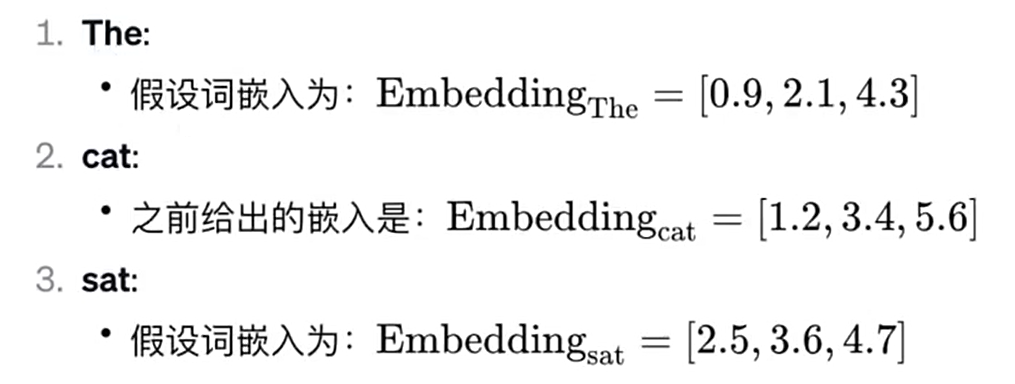

* 实现原理：通过特定算法（如Word2Vec）将语义信息编码为固定维度的向量，具体算法细节需后续深入。
* 关键特性：相似的词在向量空间中距离相近，例如"猫"和"犬"的向量夹角小于"猫"和"汽车"。

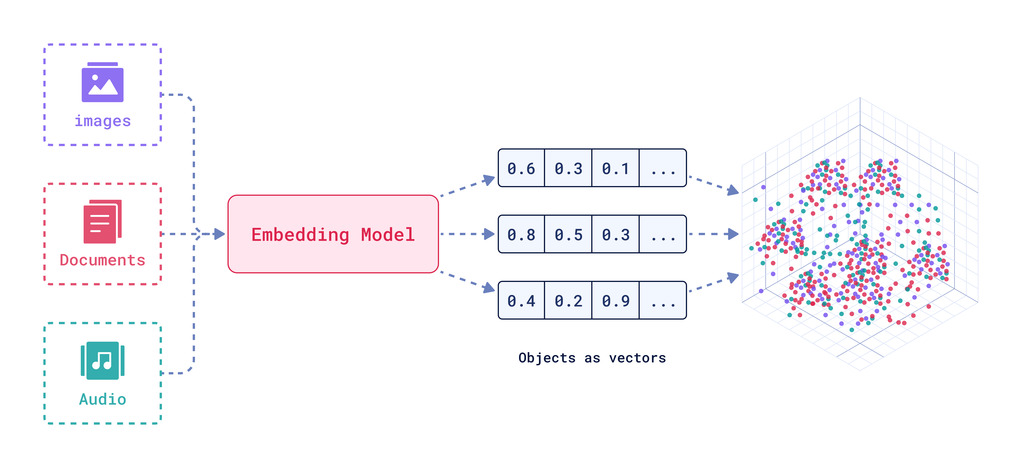

文本嵌入为 LangChain 中的问答、检索、推荐等功能提供了重要支持。具体为：
* **语义匹配：**通过计算两个文本的向量余弦相似度，判断它们在语义上的相似程度，实现语义匹配。
* **文本检索：**通过计算不同文本之间的向量相似度，可以实现语义搜索，找到向量空间中最相似的文本。
* **信息推荐：**根据用户的历史记录或兴趣嵌入生成用户向量，计算不同信息的向量与用户向量的相似度，推荐相似的信息。
* **知识挖掘：**可以通过聚类、降维等手段分析文本向量的分布，发现文本之间的潜在关联，挖掘知识。
* **自然语言处理：**将词语、句子等表示为稠密向量，为神经网络等下游任务提供输入。

### 环节5：Store（存储）
LangChain 还支持把文本嵌入存储到向量存储或临时缓存，以避免需要重新计算它们。这里就出现了数据库，支持这些嵌入的高效存储和搜索的需求。

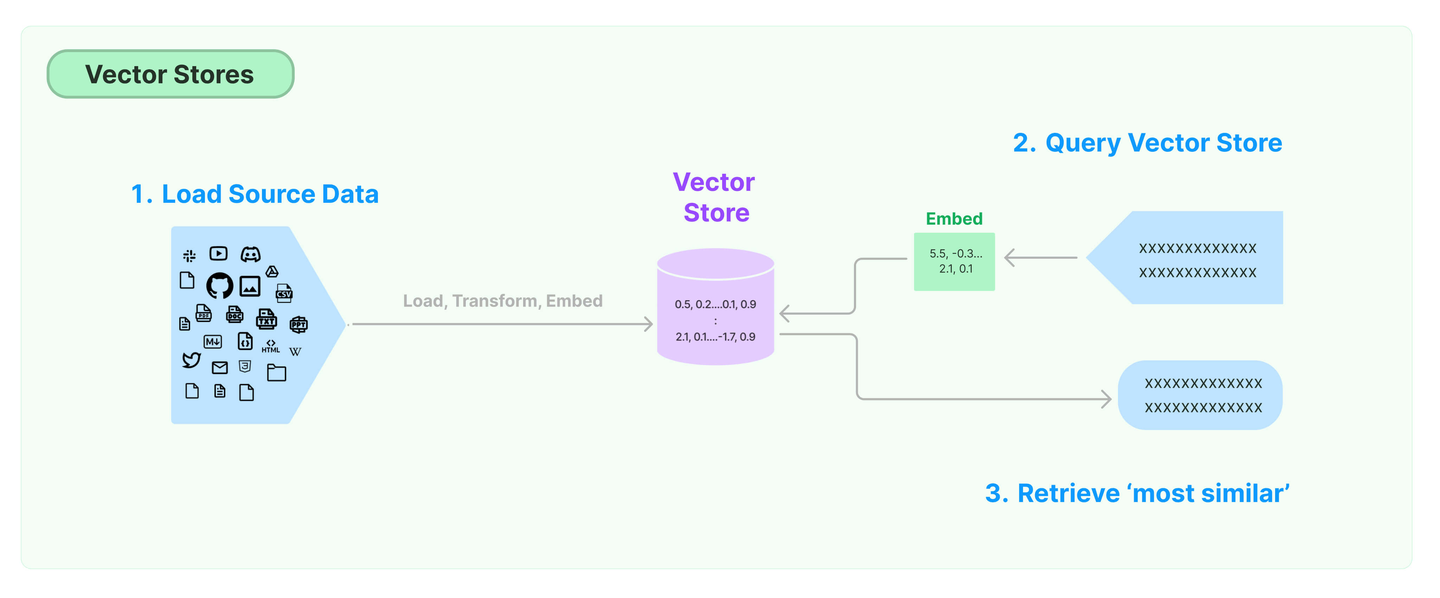

### 环节6：Retrieve（检索）
检索器（Retrievers）是一种用于响应非结构化查询的接口，它可以返回符合查询要求的文档。

LangChain 提供了一些常用的检索器，如向量检索器、文档检索器、网站研究检索器等。

通过配置不同的检索器，LangChain 可以灵活地平衡检索的精度、召回率与效率。检索结果将为后续的问答生成提供信息支持，以产生更加准确和完整的回答。
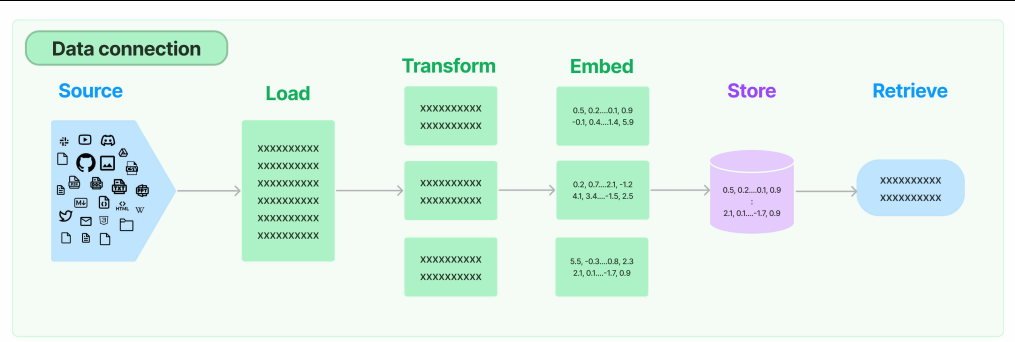

下面针对RAG的核心流程分别介绍LangChain的API，我们依次进行学习。

# 文档加载器 Document Loaders
LangChain的设计：对于Source 中多种不同的数据源，我们可以用一种统一的形式读取、调用。

## 加载txt

In [9]:
# 1.导入相关依赖
from langchain.document_loaders import TextLoader

# 2.定义TextLoader对象，file_path=".txt的位置"
text_loader = TextLoader(file_path="asset/load/01-langchain-utf-8.txt", encoding="utf-8")
# 3.加载
docs = text_loader.load()  #返回List列表(Document对象)
# 4.打印
print(docs)

[Document(metadata={'source': 'asset/load/01-langchain-utf-8.txt'}, page_content='LangChain 是一个用于构建基于大语言模型（LLM）应用的开发框架，旨在帮助开发者更高效地集成、管理和增强大语言模型的能力，构建端到端的应用程序。它提供了一套模块化工具和接口，支持从简单的文本生成到复杂的多步骤推理任务')]


Documment对象中有两个重要的属性：
* page_content：文档内容
* metadata：文档元数据

In [10]:
type(docs[0])  #langchain_core.documents.1 base.Document

langchain_core.documents.base.Document

In [11]:
docs[0].page_content

'LangChain 是一个用于构建基于大语言模型（LLM）应用的开发框架，旨在帮助开发者更高效地集成、管理和增强大语言模型的能力，构建端到端的应用程序。它提供了一套模块化工具和接口，支持从简单的文本生成到复杂的多步骤推理任务'

In [12]:
docs[0].metadata  # {'source': './data/langchain.txt'}

{'source': 'asset/load/01-langchain-utf-8.txt'}

## 加载pdf
举例1：
LangChain加载PDF文件使用的是pypdf，需要先安装下面的依赖：

`pip install pypdf`

In [2]:
# 1.导入相关的依赖 PyPDFLoader()
from langchain.document_loaders import PyPDFLoader

# 2.定义PyPDFLoader
pdfLoader = PyPDFLoader(file_path="asset/load/02-load.pdf")
# 3.加载
docs = pdfLoader.load()
print(docs)
print(type(docs[0]))
# # 4.遍历集合
# for doc in docs:
# print(f"加载的文档:{doc.page_content}")

D:\develop\miniconda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


[Document(metadata={'producer': 'Microsoft® Word 2019', 'creator': 'Microsoft® Word 2019', 'creationdate': '2025-06-20T17:18:19+08:00', 'moddate': '2025-06-20T17:18:19+08:00', 'source': 'asset/load/02-load.pdf', 'total_pages': 1, 'page': 0, 'page_label': '1'}, page_content='"他的车，他的命！ 他忽然想起来，一年，二年，至少有三四年；一滴汗，两滴汗，不\n知道多少万滴汗，才挣出那辆车。从风里雨里的咬牙，从饭里茶里的自苦，才赚出那辆车。\n那辆车是他的一切挣扎与困苦的总结果与报酬，像身经百战的武士的一颗徽章。……他老想\n着远远的一辆车，可以使他自由，独立，像自己的手脚的那么一辆车。" \n \n"他吃，他喝，他嫖，他赌，他懒，他狡猾， 因为他没了心，他的心被人家摘了去。他\n只剩下那个高大的肉架子，等着溃烂，预备着到乱死岗子去。……体面的、要强的、好梦想\n的、利己的、个人的、健壮的、伟大的祥子，不知陪着人家送了多少回殡；不知道何时何地\n会埋起他自己来， 埋起这堕落的、 自私的、 不幸的、 社会病胎里的产儿， 个人主义的末路鬼！\n"')]
<class 'langchain_core.documents.base.Document'>


举例2：加载在线的pdf文件

In [3]:
#1.导入相关依赖
from langchain.document_loaders import PyPDFLoader

# 2.定义PyPDFLoader对象,加载在线的pdf文件
py_pdfLoader = PyPDFLoader(file_path="https://arxiv.org/pdf/2302.03803")
# 3.加载
docs = py_pdfLoader.load()
print(len(docs))  # 8
# 4.打印
for doc in docs:
    print(doc)

8
page_content='arXiv:2302.03803v1  [math.AG]  7 Feb 2023
A WEAK (k, k )-LEFSCHETZ THEOREM FOR PROJECTIVE
TORIC ORBIFOLDS
William D. Montoya
Instituto de Matem´ atica, Estat´ ıstica e Computa¸ c˜ ao Cient´ ıﬁca,
Universidade Estadual de Campinas (UNICAMP),
Rua S´ ergio Buarque de Holanda 651, 13083-859, Campinas, SP , Brazil
February 9, 2023
Abstract
Firstly we show a generalization of the (1,1)-Lefschetz theorem for projective
toric orbifolds and secondly we prove that on 2k-dimensional quasi-smooth hyper-
surfaces coming from quasi-smooth intersection surfaces, under the Cayley trick,
every rational (k, k)-cohomology class is algebraic, i.e., the Hodge conjectureholds
on them.
1 Introduction
In [3] we proved that, under suitable conditions, on a very general codimension s quasi-
smooth intersection subvariety X in a projective toric orbifold Pd
Σ with d +s = 2(k +1)
the Hodge conjecture holds, that is, every (p, p )-cohomology class, under the Poincar´ e
duality is a rational linear 

举例3：使用load_and_split()，边加载边切分文档

In [5]:
# 1.导入相关的依赖 PyPDFLoader()
from langchain.document_loaders import PyPDFLoader

# 2.定义PyPDFLoader
py_pdfLoader = PyPDFLoader(file_path="./asset/load/02-load.pdf")
# 3.加载
docs = py_pdfLoader.load_and_split()  #底层默认使用了递归字符文本切分器
print(docs)

[Document(metadata={'producer': 'Microsoft® Word 2019', 'creator': 'Microsoft® Word 2019', 'creationdate': '2025-06-20T17:18:19+08:00', 'moddate': '2025-06-20T17:18:19+08:00', 'source': './asset/load/02-load.pdf', 'total_pages': 1, 'page': 0, 'page_label': '1'}, page_content='"他的车，他的命！ 他忽然想起来，一年，二年，至少有三四年；一滴汗，两滴汗，不\n知道多少万滴汗，才挣出那辆车。从风里雨里的咬牙，从饭里茶里的自苦，才赚出那辆车。\n那辆车是他的一切挣扎与困苦的总结果与报酬，像身经百战的武士的一颗徽章。……他老想\n着远远的一辆车，可以使他自由，独立，像自己的手脚的那么一辆车。" \n \n"他吃，他喝，他嫖，他赌，他懒，他狡猾， 因为他没了心，他的心被人家摘了去。他\n只剩下那个高大的肉架子，等着溃烂，预备着到乱死岗子去。……体面的、要强的、好梦想\n的、利己的、个人的、健壮的、伟大的祥子，不知陪着人家送了多少回殡；不知道何时何地\n会埋起他自己来， 埋起这堕落的、 自私的、 不幸的、 社会病胎里的产儿， 个人主义的末路鬼！\n"')]


同样，对于PyPDFLoader ，依然是使用.page_content 和.metadata 去访问数据，也就是说，每一个文档加载器虽然代码逻辑不同，应用需求不同，但使用方式是相同的。

## 加载csv
举例1：加载csv所有列

In [13]:
from langchain_community.document_loaders.csv_loader import CSVLoader

loader = CSVLoader(file_path="asset/load/03-load.csv")
data = loader.load()
print(data)
print(type(data))  # <class 'list'>
print(type(data[0]))  # <class 'langchain_core.documents.base.Document'>
print(len(data))  # 4
print(data[0].page_content)  # id: 1 title: Introduction to Python ...

[Document(metadata={'source': 'asset/load/03-load.csv', 'row': 0}, page_content='id: 1\ntitle: Introduction to Python\ncontent: Python is a popular programming language.\nauthor: John Doe'), Document(metadata={'source': 'asset/load/03-load.csv', 'row': 1}, page_content='id: 2\ntitle: Data Science Basics\ncontent: Data science involves statistics and machine learning.\nauthor: Jane Smith'), Document(metadata={'source': 'asset/load/03-load.csv', 'row': 2}, page_content='id: 3\ntitle: Web Development\ncontent: HTML, CSS and JavaScript are core web technologies.\nauthor: Mike Johnson'), Document(metadata={'source': 'asset/load/03-load.csv', 'row': 3}, page_content='id: 4\ntitle: Artificial Intelligence\ncontent: AI is transforming many industries.\nauthor: Sarah Williams')]
<class 'list'>
<class 'langchain_core.documents.base.Document'>
4
id: 1
title: Introduction to Python
content: Python is a popular programming language.
author: John Doe


举例2：
使用 source_column 参数指定文件加载的列，保存在source变量中。

In [14]:
from langchain_community.document_loaders.csv_loader import CSVLoader

loader = CSVLoader(
    file_path="./asset/load/03-load.csv",
    source_column='author'
)
data = loader.load()
print(data)

[Document(metadata={'source': 'John Doe', 'row': 0}, page_content='id: 1\ntitle: Introduction to Python\ncontent: Python is a popular programming language.\nauthor: John Doe'), Document(metadata={'source': 'Jane Smith', 'row': 1}, page_content='id: 2\ntitle: Data Science Basics\ncontent: Data science involves statistics and machine learning.\nauthor: Jane Smith'), Document(metadata={'source': 'Mike Johnson', 'row': 2}, page_content='id: 3\ntitle: Web Development\ncontent: HTML, CSS and JavaScript are core web technologies.\nauthor: Mike Johnson'), Document(metadata={'source': 'Sarah Williams', 'row': 3}, page_content='id: 4\ntitle: Artificial Intelligence\ncontent: AI is transforming many industries.\nauthor: Sarah Williams')]


## 加载JSON
LangChain提供的JSON格式的文档加载器是JSONLoader 。在实际应用场景中，JSON格式的数据占有很大比例，而且JSON的形式也是多样的。我们需要特别关注。

JSONLoader 使用指定的 `jq`结构来解析 JSON 文件。`jq`是一个轻量级的命令行 JSON 处理器 ，可以对JSON 格式的数据进行各种复杂的处理，包括数据过滤、映射、减少和转换，是处理 JSON 数据的首选工具之一。
> pip install jq

举例1：使用JSONLoader文档加载器加载

In [16]:
# 1.导入依赖
from langchain_community.document_loaders import JSONLoader
from pprint import pprint

# 2.定义JSONLoader对象
# 错误的
# json_loader=JSONLoader(file_path="asset/load/04-load.json")
# 情况1
# json_loader=JSONLoader(
# file_path="asset/load/04-load.json",
# jq_schema=".", #直接提取完整的JSON对象（包括所有字段）
# text_content=False #保持原始 JSON 结构，将提取的数据转换为JSON字符串存入page_content字段中
# )
# 情况2
# .messages[].content:遍历.messages[]中所有元素 从每一个元素中提取.content字段
json_loader = JSONLoader(
    file_path="asset/load/04-load.json",
    jq_schema=".messages[].content"
)
# 3.加载
docs = json_loader.load()
pprint(docs)
# 4.提取content中指定字符数的内容
# print(docs[0].page_content[:10])

[Document(metadata={'source': 'D:\\code\\py\\langchain\\codes\\chapter07-RAG\\asset\\load\\04-load.json', 'seq_num': 1}, page_content='Hello, how are you today?'),
 Document(metadata={'source': 'D:\\code\\py\\langchain\\codes\\chapter07-RAG\\asset\\load\\04-load.json', 'seq_num': 2}, page_content="I'm doing well, thanks for asking!"),
 Document(metadata={'source': 'D:\\code\\py\\langchain\\codes\\chapter07-RAG\\asset\\load\\04-load.json', 'seq_num': 3}, page_content='Would you like to meet for lunch?'),
 Document(metadata={'source': 'D:\\code\\py\\langchain\\codes\\chapter07-RAG\\asset\\load\\04-load.json', 'seq_num': 4}, page_content='Sure, that sounds great!')]


举例2：提取04-response.json文件中嵌套在 data.items[].content 的文本

如果希望处理 JSON 中的 嵌套字段、数组元素提取，可以使用 content_key 配合is_content_key_jq_parsable=True ，通过 jq 语法精准定位目标数据。

通常，对api请求结果的采集

In [19]:
# 1.导入相关依赖
from langchain_community.document_loaders import JSONLoader
from pprint import pprint

# 2.定义json文件的路径
file_path = 'asset/load/04-response.json'
# 3.定义JSONLoader对象
# 提取嵌套在 data.items[].content 的文本，并保留其他字段作为元数据
# 方式1：
# loader = JSONLoader(
# file_path=file_path,
# jq_schema=".data.items[].content",
# )
# 方式2：
loader = JSONLoader(
    file_path=file_path,
    jq_schema=".data.items[]",  # 先定位到数组条目
    content_key=".content",  # 再从条目中提取 content 字段
    is_content_key_jq_parsable=True  # 用jq解析content_key
)
# 4.加载
data = loader.load()
pprint(data)
pprint(data[0].page_content)

[Document(metadata={'source': 'D:\\code\\py\\langchain\\codes\\chapter07-RAG\\asset\\load\\04-response.json', 'seq_num': 1}, page_content='This article explains how to parse API responses...'),
 Document(metadata={'source': 'D:\\code\\py\\langchain\\codes\\chapter07-RAG\\asset\\load\\04-response.json', 'seq_num': 2}, page_content='Learn to handle nested structures with...'),
 Document(metadata={'source': 'D:\\code\\py\\langchain\\codes\\chapter07-RAG\\asset\\load\\04-response.json', 'seq_num': 3}, page_content='Best practices for preserving metadata...')]
'This article explains how to parse API responses...'


## 加载HTML(了解)
> pip install unstructured

In [21]:
# 1.导入相关的依赖
from langchain.document_loaders import UnstructuredHTMLLoader

# 2.定义UnstructuredHTMLLoader对象
# strategy:
# "fast" 解析加载html文件速度是比较快（但可能丢失部分结构或元数据）
# "hi_res": (高分辨率解析) 解析精准（速度慢一些）
# "ocr_only" 强制使用ocr提取文本，仅仅适用于图像（对HTML无效）
# mode ：one of `{'paged', 'elements', 'single'}
# "elements" 按语义元素（标题、段落、列表、表格等）拆分成多个独立的小文档
html_loader = UnstructuredHTMLLoader(
    file_path="asset/load/05-load.html",
    mode="elements",
    strategy="fast"
)
# 3.加载
docs = html_loader.load()
print(len(docs))  # 16
# 4.打印
for doc in docs:
    print(doc)

16
page_content='首发于自然语言处理算法与实践' metadata={'source': 'asset/load/05-load.html', 'last_modified': '2025-09-19T23:52:48', 'languages': ['zho'], 'file_directory': 'asset/load', 'filename': '05-load.html', 'filetype': 'text/html', 'category': 'UncategorizedText', 'element_id': 'b082a3e1f4714ffa5f25741f39d82c17'}
page_content='RAG:将检索与生成方式相结合来做生成任务' metadata={'source': 'asset/load/05-load.html', 'category_depth': 0, 'last_modified': '2025-09-19T23:52:48', 'languages': ['kor'], 'file_directory': 'asset/load', 'filename': '05-load.html', 'filetype': 'text/html', 'category': 'Title', 'element_id': '46103fd31eae47ed36481d13185af8a9'}
page_content='烛之文' metadata={'source': 'asset/load/05-load.html', 'last_modified': '2025-09-19T23:52:48', 'languages': ['kor'], 'file_directory': 'asset/load', 'filename': '05-load.html', 'filetype': 'text/html', 'parent_id': '46103fd31eae47ed36481d13185af8a9', 'category': 'UncategorizedText', 'element_id': 'e02798c2e2bb964165a9e9356b82a3f6'}
page_content='1、前言' me

## 加载File Directory(了解)
> pip install unstructured

In [ ]:
# 1.导入相关的依赖
from langchain.document_loaders import DirectoryLoader
from langchain.document_loaders import PythonLoader
from pprint import pprint

# 2.定义DirectoryLoader对象,指定要加载的文件夹路径、要加载的文件类型和是否使用多线程
directory_loader = DirectoryLoader(
    path="./asset/load",
    glob="*.py",
    use_multithreading=True,
    show_progress=True,
    loader_cls=PythonLoader
)
# 3.加载
docs = directory_loader.load()
# 4.打印
print(len(docs))
for doc in docs:
    pprint(doc)

# 文档拆分器 Text Splitters
## 为什么要拆分/分块/切分
当拿到统一的一个Document对象后，接下来需要切分成Chunks。如果不切分，而是考虑作为一个整体的Document对象，会存在两点问题：

1. 假设提问的Query的答案出现在某一个Document对象中，那么将检索到的整个Document对象
直接放入Prompt中并不是最优的选择，因为其中一定会包含非常多无关的信息，而无效信息越
多，对大模型后续的推理影响越大。
2. 任何一个大模型都存在最大输入的Token限制，如果一个Document非常大，比如一个几百兆的
PDF，那么大模型肯定无法容纳如此多的信息。

基于此，一个有效的解决方案就是将完整的Document对象进行分块处理（Chunking) 。无论是在存储还是检索过程中，都将以这些块(chunks) 为基本单位，这样有效地避免内容不相关性问题和超出最大输入限制的问题。

## Chunking拆分的策略
**方法1： 根据句子切分：** 这种方法按照自然句子边界进行切分，以保持语义完整性。

**方法2： 按照固定字符数来切分：** 这种策略根据特定的字符数量来划分文本，但可能会在不适当的位置切断句子。

**方法3： 按固定字符数来切分，结合重叠窗口（overlapping windows）：** 此方法与按字符数切分相似，但通过重叠窗口技术避免切分关键内容，确保信息连贯性。

**方法4：递归字符切分方法：** 通过递归字符方式动态确定切分点，这种方法可以根据文档的复杂性和内容密度来调整块的大小。

**方法5：根据语义内容切分：** 这种高级策略依据文本的语义内容来划分块，旨在保持相关信息的集中和完整，适用于需要高度语义保持的应用场景。

> 第2种⽅法（按照字符数切分）和第3种⽅法（按固定字符数切分结合重叠窗口）主要基于字符进⾏⽂本的切分，而不考虑⽂章的实际内容和语义。这种⽅式虽简单，但可能会导致主题或语义上的断裂。
>
> 相对而⾔，第4种递归⽅法更加灵活和⾼效，它结合了固定⻓度切分和语义分析。通常是首选策略，因为它能够更好地确保每个段落包含⼀个完整的主题。
>
> 而第5种⽅法，基于语义的分割虽然能精确地切分出完整的主题段落，但这种⽅法效率较低。它需要运⾏复杂的分段算法（segmentation algorithm）， 处理速度较慢，并且段落长度可能极不均匀（有的主题段落可能很⻓，而有的则较短）。因此，尽管它在某些需要⾼精度语义保持的场景下有其应⽤价值，但并不适合所有情况。
>
这些方法各有优势和局限，选择适当的分块策略取决于具体的应用需求和预期的检索效果。接下来我们
依次尝试用常规手段应该如何实现上述几种方法的文本切分

## 具体代码实现
LangChain提供了许多不同类型的文档切分器

官网地址：https://python.langchain.com/api_reference/text_splitters/index.html

### CharacterTextSplitter：文本切分器
参数情况说明：
* **chunk_size** ：每个切块的最大token数量，默认值为4000。
* **chunk_overlap** ：相邻两个切块之间的最大重叠token数量，默认值为200。
* **separator** ：分割使用的分隔符，默认值为"\n\n"。
* **`length_function`** ：用于计算切块长度的方法。默认赋值为父类TextSplitter的len函数。

举例1：字符串文本的分割

In [23]:
# 1.导入相关依赖
from langchain.text_splitter import CharacterTextSplitter

# 2.示例文本
text = """
LangChain 是一个用于开发由语言模型驱动的应用程序的框架的。它提供了一套工具和抽象，使开发者
能够更容易地构建复杂的应用程序。
"""
# 3.定义字符分割器
splitter = CharacterTextSplitter(
    chunk_size=50,  # 每块大小
    chunk_overlap=5,  # 块与块之间的重复字符数
    #length_function=len,
    separator=""  # 设置为空字符串时，表示禁用分隔符优先
)
# 4.分割文本
texts = splitter.split_text(text)
# 5.打印结果
for i, chunk in enumerate(texts):
    print(f"块 {i + 1}:长度：{len(chunk)}")
    print(chunk)
    print("-" * 50)

块 1:长度：49
LangChain 是一个用于开发由语言模型驱动的应用程序的框架的。它提供了一套工具和抽象，使开发
--------------------------------------------------
块 2:长度：23
象，使开发者
能够更容易地构建复杂的应用程序。
--------------------------------------------------


举例2：指定分割符

In [24]:
# 1.导入相关依赖
from langchain.text_splitter import CharacterTextSplitter

# 2.定义要分割的文本
text = "这是一个示例文本啊。我们将使用CharacterTextSplitter将其分割成小块。分割基于字符数。"
# text = """
# LangChain 是一个用于开发由语言模型。驱动的应用程序的框架的。它提供了一套工具和抽象。使开发者能够更容易地构建复杂的应用程序。
# """
# 3.定义分割器实例
text_splitter = CharacterTextSplitter(
    chunk_size=30,  # 每个块的最大字符数
    chunk_overlap=5,  # 块之间的重叠字符数
    separator="。",  # 按句号分割
)
# 4.开始分割
chunks = text_splitter.split_text(text)
# 5.打印效果
for i, chunk in enumerate(chunks):
    print(f"块 {i + 1}:长度：{len(chunk)}")
    print(chunk)
    print("-" * 50)

Created a chunk of size 33, which is longer than the specified 30


块 1:长度：9
这是一个示例文本啊
--------------------------------------------------
块 2:长度：33
我们将使用CharacterTextSplitter将其分割成小块
--------------------------------------------------
块 3:长度：7
分割基于字符数
--------------------------------------------------


注意：这里没有重叠。

**separator优先原则：** 当设置了 separator （如"。"），分割器会首先尝试在分隔符处分割，然后再考虑 `chunk_size`。这是为了避免在句子中间硬性切断。这种设计是为了：
1. 优先保持语义完整性（不切断句子）
2. 避免产生无意义的碎片（如半个单词/不完整句子）
3. 如果 chunk_size 比片段小，无法拆分片段，导致 overlap失效。

### RecursiveCharacterTextSplitter 递归字符切分器（推荐使用）
文档切分器中较常用的是RecursiveCharacterTextSplitter (递归字符文本切分器) ，遇到特定字符时进行分割。默认情况下，它尝试进行切割的字符包括 ["\n\n", "\n", " ", ""] 。

具体为：根据第一个字符进行切块，但如果任何切块太大，则会继续移动到下一个字符继续切块，以此类推。

此外，还可以考虑添加`，。`等分割字符。

**特点：**
* 保留上下文：优先在自然语言边界（如段落、句子结尾）处分割， 减少信息碎片化。
* 智能分段：通过递归尝试多种分隔符，将文本分割为大小接近chunk_size的片段。
* 灵活适配：适用于多种文本类型（代码、Markdown、普通文本等），是LangChain中最通用的文本拆分器

举例1：使用split_text()方法演示

In [25]:
# 1.导入相关依赖
from langchain.text_splitter import RecursiveCharacterTextSplitter

# 2.定义RecursiveCharacterTextSplitter分割器对象
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=10,
    chunk_overlap=0,
    add_start_index=True,
)
# 3.定义拆分的内容
text = "LangChain框架特性\n\n多模型集成(GPT/Claude)\n记忆管理功能\n链式调用设计。文档分析场景示例：需要处理PDF / Word等格式。"
# 4.拆分器分割
paragraphs = text_splitter.split_text(text)
for para in paragraphs:
    print(para)
    print('-------')

LangChain框
-------
架特性
-------
多模型集成(GPT
-------
/Claude)
-------
记忆管理功能
-------
链式调用设计。文档
-------
分析场景示例：需要处
-------
理PDF
-------
/
-------
Word等格式。
-------


举例2：使用create_documents()方法演示，传入字符串列表，返回Document对象列表

In [26]:
# 1.导入相关依赖
from langchain.text_splitter import RecursiveCharacterTextSplitter

# 2.定义RecursiveCharacterTextSplitter分割器对象
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=10,
    chunk_overlap=0,
    add_start_index=True,
)
# 3.定义分割的内容
# text="LangChain框架特性\n\n多模型集成(GPT/Claude)\n记忆管理功能\n链式调用设计。文档分析场景示例：需要处理PDF/Word等格式。"
list = [
    "LangChain框架特性\n\n多模型集成(GPT/Claude)\n记忆管理功能\n链式调用设计。文档分析场景示例：需要处理PDF/Word等格式。"]
# 4.分割器分割
# create_documents()：形参是字符串列表，返回值是Document的列表
paragraphs = text_splitter.create_documents(list)
for para in paragraphs:
    print(para)
    print('-------')

page_content='LangChain框' metadata={'start_index': 0}
-------
page_content='架特性' metadata={'start_index': 10}
-------
page_content='多模型集成(GPT' metadata={'start_index': 15}
-------
page_content='/Claude)' metadata={'start_index': 24}
-------
page_content='记忆管理功能' metadata={'start_index': 33}
-------
page_content='链式调用设计。文档' metadata={'start_index': 40}
-------
page_content='分析场景示例：需要处' metadata={'start_index': 49}
-------
page_content='理PDF/Word等' metadata={'start_index': 59}
-------
page_content='格式。' metadata={'start_index': 69}
-------


举例3：使用create_documents()方法演示，将本地文件内容加载成字符串，进行拆分

In [27]:
# 1.导入相关依赖
from langchain_text_splitters import RecursiveCharacterTextSplitter

# 2.打开.txt文件
with open("asset/load/08-ai.txt", encoding="utf-8") as f:
    state_of_the_union = f.read()  #返回的是字符串
# 3.定义RecursiveCharacterTextSplitter（递归字符分割器）
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=100,
    chunk_overlap=20,
    #chunk_overlap=0,
    length_function=len
)
# 4.分割文本
texts = text_splitter.create_documents([state_of_the_union])
# 5.打印分割文本
for text in texts:
    print(f"🔥{text.page_content}")

🔥人工智能（AI）是什么？
🔥人工智能（Artificial
🔥Intelligence，简称AI）是指由计算机系统模拟人类智能的技术，使其能够执行通常需要人类认知能力的任务，如学习、推理、决策和语言理解。AI的核心目标是让机器具备感知环境、处理信息并自主行动的
🔥让机器具备感知环境、处理信息并自主行动的能力。
🔥1. AI的技术基础
AI依赖多种关键技术：

机器学习（ML）：通过算法让计算机从数据中学习规律，无需显式编程。例如，推荐系统通过用户历史行为预测偏好。
🔥深度学习：基于神经网络的机器学习分支，擅长处理图像、语音等复杂数据。AlphaGo击败围棋冠军便是典型案例。

自然语言处理（NLP）：使计算机理解、生成人类语言，如ChatGPT的对话能力。
🔥2. AI的应用场景
AI已渗透到日常生活和各行各业：

医疗：辅助诊断（如AI分析医学影像）、药物研发加速。

交通：自动驾驶汽车通过传感器和AI算法实现安全导航。
🔥金融：欺诈检测、智能投顾（如风险评估模型）。

教育：个性化学习平台根据学生表现调整教学内容。

3. AI的挑战与未来
尽管前景广阔，AI仍面临问题：
🔥伦理争议：数据隐私、算法偏见（如招聘AI歧视特定群体）。

就业影响：自动化可能取代部分人工岗位，但也会创造新职业。

技术瓶颈：通用人工智能（AGI）尚未实现，当前AI仅擅长特定任务。
🔥未来，AI将与人类协作而非替代：医生借助AI提高诊断效率，教师利用AI定制课程。其发展需平衡技术创新与社会责任，确保技术造福全人类。


举例4：使用split_documents()方法演示，利用PDFLoader加载文档，对文档的内容用递归切割器切割

In [ ]:
# 1.导入相关依赖
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

# 2.定义PyPDFLoader加载器
loader = PyPDFLoader("./asset/load/02-load.pdf")
# 3.加载和切割文档对象
docs = loader.load()  # 返回Document对象构成的list
# print(f"第0页：\n{docs[0]}")
# 4.定义切割器
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=200,
    #chunk_size=120,
    chunk_overlap=0,
    # chunk_overlap=100,
    length_function=len,
    add_start_index=True,
)
# 5.对pdf内容进行切割得到文档对象
paragraphs = text_splitter.split_documents(docs)
#paragraphs = text_splitter.create_documents([text])
for para in paragraphs:
    print(para.page_content)
    print('-------')

举例5：自定义分隔符

有些书写系统没有单词边界，例如中文、日文和泰文。使用默认分隔符列表["\n\n", "\n", " ", ""]分割文
本可能导致单词错误的分割。为了保持单词在一起，你可以自定义分割字符，覆盖分隔符列表以包含额
外的标点符号。

In [ ]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=200,
    chunk_overlap=20,  # 增加重叠字符
    separators=["\n\n", "\n", "。", "！", "？", "……", "，", ""],  # 添加中文标点
    length_function=len,
    keep_separator=True  #保留句尾标点（如 ……），避免切割后丢失语气和逻辑
)

效果：算法优先在句号、省略号处切割，保持句子完整性。

### TokenTextSplitter 基于token数的切分器
**TokenTextSplitter 使用说明：**
* 核心依据：Token数量 + 自然边界。（TokenTextSplitter 严格按照 token 数量进行分割，但同时会优先在自然边界（如句尾）处切断，以尽量保证语义的完整性。）
* 优点：与LLM的Token计数逻辑一致，能尽量保持语义完整
* 缺点：对非英语或特定领域文本，Token化效果可能不佳
* 典型场景：需要精确控制Token数输入LLM的场景

举例1：使用TokenTextSplitter

In [28]:
# 1.导入相关依赖
from langchain_text_splitters import TokenTextSplitter

# 2.初始化 TokenTextSplitter
text_splitter = TokenTextSplitter(
    chunk_size=33,  #最大 token 数为 32
    chunk_overlap=0,  #重叠 token 数为 0
    encoding_name="cl100k_base",  # 使用 OpenAI 的编码器,将文本转换为 token 序列
)
# 3.定义文本
text = "人工智能是一个强大的开发框架。它支持多种语言模型和工具链。人工智能是指通过计算机程序模拟人类智能的一门科学。自20世纪50年代诞生以来，人工智能经历了多次起伏。"
# 4.开始切割
texts = text_splitter.split_text(text)
# 打印分割结果
print(f"原始文本被分割成了 {len(texts)} 个块:")
for i, chunk in enumerate(texts):
    print(f"块 {i + 1}: 长度：{len(chunk)} 内容：{chunk}")
    print("-" * 50)

原始文本被分割成了 3 个块:
块 1: 长度：29 内容：人工智能是一个强大的开发框架。它支持多种语言模型和工具链。
--------------------------------------------------
块 2: 长度：32 内容：人工智能是指通过计算机程序模拟人类智能的一门科学。自20世纪50
--------------------------------------------------
块 3: 长度：19 内容：年代诞生以来，人工智能经历了多次起伏。
--------------------------------------------------


**为什么会出现这样的分割？**

1、第一块 (29字符) ：内容是一个完整的句子，以句号结尾。TokenTextSplitter识别到这是一个自然的语义边界，即使这里的 token 数量可能尚未达到 33，它也选择在此处切割，以保证第一块语义的完整性。

2、第二块 (32字符) ：内容包含了另一个完整句子 “人工智能是指...一门科学。” 以及下一句的开头 “自20世纪50” 。分割器在处理完第一个句子的 token 后，可能 token 数量已经接近 chunk_size ，于是在下一个自然边界（这里是句号）之后继续读取了少量 token（“自20世纪50”），直到非常接近 33token 的限制。

注意：“50” 之后被切断，是因为编码器很可能将“50”识别为一个独立的 token，而“年代”是另
一个 token。为了保证 token 的完整性，它不会在“50”字符中间切断。

3、第三块 (19字符) ：是第二块中断内容的剩余部分，形成了一个较短的块。这是因为剩余内容本身的token 数量就较少。

**特别注意：字符长度不等于 Token 数量。**

### SemanticChunker：语义分块
SemanticChunking（语义分块）是 LangChain 中一种更高级的文本分割方法，它超越了传统的基于字
符或固定大小的分块方式，而是根据文本的语义结构进行智能分块，使每个分块保持语义完整性，从而
提高检索增强生成(RAG)等应用的效果。

语义分割 vs 传统分割

| 特性 | 语义分割（SemanticChunker） | 传统字符分割（RecursiveCharacter） |
| --- | --- | --- |
| 分割依据 | 嵌入向量相似度 | 固定字符/换行符 |
| 语义完整性 | ✅ 保持主题连贯 | ❌ 可能切断句子逻辑 |
| 计算成本 | ❌ 高（需嵌入模型） | ✅ 低 |
| 适用场景 | 需要高语义一致性的任务 | 简单文本预处理 |


In [29]:
from langchain_experimental.text_splitter import SemanticChunker
from langchain_openai.embeddings import OpenAIEmbeddings
import os
import dotenv

dotenv.load_dotenv()
# 加载文本
with open("asset/load/09-ai1.txt", encoding="utf-8") as f:
    state_of_the_union = f.read()  #返回字符串
# 获取嵌入模型
os.environ['OPENAI_API_KEY'] = os.getenv("OPENAI_API_KEY")
os.environ['OPENAI_BASE_URL'] = os.getenv("OPENAI_BASE_URL")
embed_model = OpenAIEmbeddings(
    model="text-embedding-3-large"
)
# 获取切割器
text_splitter = SemanticChunker(
    embeddings=embed_model,
    breakpoint_threshold_type="percentile",  #断点阈值类型：字面值["百分位数", "标准差", "四分位距", "梯度"] 选其一
    breakpoint_threshold_amount=65.0  #断点阈值数量 (极低阈值 → 高分割敏感度)
)
# 切分文档
docs = text_splitter.create_documents(texts=[state_of_the_union])
print(len(docs))
for doc in docs:
    print(f"🔍 文档 {doc}:")

4
🔍 文档 page_content='人工智能综述：发展、应用与未来展望

摘要
人工智能（Artificial Intelligence，AI）作为计算机科学的一个重要分支，近年来取得了突飞猛进的发展。本文综述了人工智能的发展历程、核心技术、应用领域以及未来发展趋势。通过对人工智能的定义、历史背景、主要技术（如机器学习、深度学习、自然语言处理等）的详细介绍，探讨了人工智能在医疗、金融、教育、交通等领域的应用，并分析了人工智能发展过程中面临的挑战与机遇。最后，本文对人工智能的未来发展进行了展望，提出了可能的突破方向。

1. 引言
人工智能是指通过计算机程序模拟人类智能的一门科学。自20世纪50年代诞生以来，人工智能经历了多次起伏，近年来随着计算能力的提升和大数据的普及，人工智能技术取得了显著的进展。人工智能的应用已经渗透到日常生活的方方面面，从智能手机的语音助手到自动驾驶汽车，从医疗诊断到金融分析，人工智能正在改变着人类社会的运行方式。

2.':
🔍 文档 page_content='人工智能的发展历程
2.1 早期发展
人工智能的概念最早可以追溯到20世纪50年代。1956年，达特茅斯会议（Dartmouth Conference）被认为是人工智能研究的正式开端。在随后的几十年里，人工智能研究经历了多次高潮与低谷。早期的研究主要集中在符号逻辑和专家系统上，但由于计算能力的限制和算法的不足，进展缓慢。
2.2 机器学习的兴起
20世纪90年代，随着统计学习方法的引入，机器学习逐渐成为人工智能研究的主流。支持向量机（SVM）、决策树、随机森林等算法在分类和回归任务中取得了良好的效果。这一时期，机器学习开始应用于数据挖掘、模式识别等领域。
2.3 深度学习的突破
2012年，深度学习在图像识别领域取得了突破性进展，标志着人工智能进入了一个新的阶段。深度学习通过多层神经网络模拟人脑的工作方式，能够自动提取特征并进行复杂的模式识别。卷积神经网络（CNN）、循环神经网络（RNN）和长短期记忆网络（LSTM）等深度学习模型在图像处理、自然语言处理、语音识别等领域取得了显著成果。

3. 人工智能的核心技术
3.1 机器学习
机器学习是人工智能的核心技术之一，通过算法使计算机从数据中学习并做出决策。常见的机器学习算法包括监督学习、无监督学习和强化学习。监督学习通过标记数据

关于参数的说明：

1、breakpoint_threshold_type （断点阈值类型）

* 作用：定义文本语义边界的检测算法，决定何时分割文本块。
* 可选值及原理：

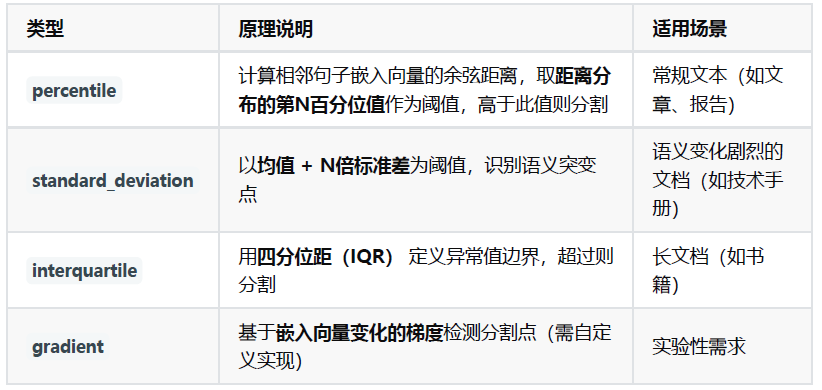

2、breakpoint_threshold_amount （断点阈值量）
* 作用：控制分割的粒度敏感度，值越小分割越细（块越多），值越大分割越粗（块越少）。
* 取值范围与示例：
    * percentile 模式：0.0~100.0，用户代码设 65.0 表示仅当余弦距离 > 所有距离中最低的65.0%值时分割 。默认值是：95.0，兼顾语义完整性与检索效率。值过小（比如0.1），会产生大量小文本块，过度分割可能导致上下文断裂。
    * standard_deviation 模式：浮点数（如 1.5 表示均值+1.5倍标准差）。
    * interquartile 模式：倍数（如 1.5 是IQR标准值）。

### 其它拆分器（了解）
**类型1：HTMLHeaderTextSplitter：Split by HTML header**

HTMLHeaderTextSplitter是一种专门用于处理HTML文档的文本分割方法，它根据HTML的标题标签
（如`<h1>、<h2>`等） 将文档划分为逻辑分块，同时保留标题的层级结构信息。

In [31]:
# 1.导入相关依赖
from langchain.text_splitter import HTMLHeaderTextSplitter

# 2.定义HTML文件
html_string = """
<!DOCTYPE html>
<html>
<body>
<div>
<h1>欢迎来到水上乐园！</h1>
<p>水上乐园是专门培训IT技术方向</p>
<div>
<h2>水上乐园老师简介</h2>
<p>水上乐园老师拥有多年教学经验，都是从一线互联网下来</p>
<h3>水上乐园北京校区</h3>
<p>北京校区位于宏福科技园区</p>
</div>
</div>
</body>
</html>
"""
# 4.用于指定要根据哪些HTML标签来分割文本
headers_to_split_on = [
    ("h1", "标题1"),
    ("h2", "标题2"),
    ("h3", "标题3"),
]
# 5.定义HTMLHeaderTextSplitter分割器
html_splitter = HTMLHeaderTextSplitter(headers_to_split_on=headers_to_split_on)
# 6.分割器分割
html_header_splits = html_splitter.split_text(html_string)
print(html_header_splits)

[Document(metadata={'标题1': '欢迎来到水上乐园！'}, page_content='欢迎来到水上乐园！'), Document(metadata={'标题1': '欢迎来到水上乐园！'}, page_content='水上乐园是专门培训IT技术方向'), Document(metadata={'标题1': '欢迎来到水上乐园！', '标题2': '水上乐园老师简介'}, page_content='水上乐园老师简介'), Document(metadata={'标题1': '欢迎来到水上乐园！', '标题2': '水上乐园老师简介'}, page_content='水上乐园老师拥有多年教学经验，都是从一线互联网下来'), Document(metadata={'标题1': '欢迎来到水上乐园！', '标题2': '水上乐园老师简介', '标题3': '水上乐园北京校区'}, page_content='水上乐园北京校区'), Document(metadata={'标题1': '欢迎来到水上乐园！', '标题2': '水上乐园老师简介', '标题3': '水上乐园北京校区'}, page_content='北京校区位于宏福科技园区')]


类型2：CodeTextSplitter：Split code

In [32]:
# 1.导入相关依赖
from langchain.text_splitter import (
    Language,
    RecursiveCharacterTextSplitter,
)
from pprint import pprint

# 2.定义要分割的python代码片段
PYTHON_CODE = """
def hello_world():
print("Hello, World!")
def hello_world1():
print("Hello, World1!")
"""
# 3.定义递归字符切分器
python_splitter = RecursiveCharacterTextSplitter.from_language(
    language=Language.PYTHON,
    chunk_size=50,
    chunk_overlap=0
)
# 4.文档切分
python_docs = python_splitter.create_documents(texts=[PYTHON_CODE])
pprint(python_docs)

[Document(metadata={}, page_content='def hello_world():\nprint("Hello, World!")'),
 Document(metadata={}, page_content='def hello_world1():\nprint("Hello, World1!")')]


**类型3：MarkdownTextSplitter：md数据类型**

因为Markdown格式有特定的语法，一般整体内容由h1、h2、h3 等多级标题组织，所以
MarkdownHeaderTextSplitter的切分策略就是根据标题来分割文本内容。

In [33]:
from langchain.text_splitter import MarkdownTextSplitter

markdown_text = """
# 一级标题\n
这是一级标题下的内容\n\n
## 二级标题\n
- 二级下列表项1\n
- 二级下列表项2\n
"""
# 关键步骤：直接修改实例属性
splitter = MarkdownTextSplitter(chunk_size=30, chunk_overlap=0)
splitter._is_separator_regex = True  # 强制将分隔符视为正则表达式
# 执行分割
docs = splitter.create_documents(texts=[markdown_text])
# print(len(docs))
for i, doc in enumerate(docs):
    print(f"\n🔍 分块 {i + 1}:")
    print(doc.page_content)


🔍 分块 1:
# 一级标题

这是一级标题下的内容

🔍 分块 2:
## 二级标题

- 二级下列表项1

- 二级下列表项2


# 文档嵌入模型 Text Embedding Models
## 嵌入模型概述
Text Embedding Models：文档嵌入模型，提供将文本编码为向量的能力，即文档向量化。文档写入
和用户查询匹配前都会先执行文档嵌入编码，即向量化。

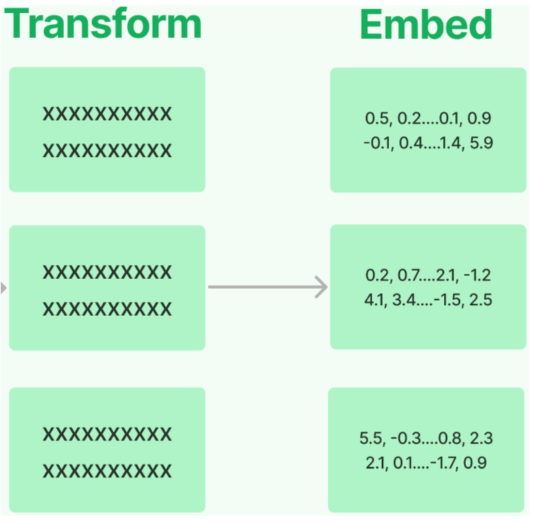

LangChain中针对向量化模型的封装提供了两种接口，一种针对文档的向量化(embed_documents) ，一种针对句子的向量化embed_query 。

句子的向量化就是对单个字符串进行向量化；

文档的向量化就是对字符串列表进行向量化。

## 句子的向量化（embed_query）

In [34]:
from langchain_openai import OpenAIEmbeddings
import os
import dotenv

dotenv.load_dotenv()
os.environ['OPENAI_API_KEY'] = os.getenv("OPENAI_API_KEY")
os.environ['OPENAI_BASE_URL'] = os.getenv("OPENAI_BASE_URL")
# 初始化嵌入模型
embeddings_model = OpenAIEmbeddings(model="text-embedding-ada-002")
#embeddings_model = OpenAIEmbeddings(model="text-embedding-3-large")
# 待嵌入的文本句子
text = "What was the name mentioned in the conversation?"
# 生成一个嵌入向量
embedded_query = embeddings_model.embed_query(text=text)
# 使用embedded_query[:5]来查看前5个元素的值
print(embedded_query[:5])
print(len(embedded_query))

[0.005329647101461887, -0.0006122003542259336, 0.0389961302280426, -0.002898985054343939, -0.008904732763767242]
1536


## 文档的向量化（embed_documents）

In [35]:
from langchain_openai import OpenAIEmbeddings
import os
import dotenv

dotenv.load_dotenv()
os.environ['OPENAI_API_KEY'] = os.getenv("OPENAI_API_KEY")
os.environ['OPENAI_BASE_URL'] = os.getenv("OPENAI_BASE_URL")
# 初始化嵌入模型
embeddings_model = OpenAIEmbeddings(model="text-embedding-ada-002")
# 待嵌入的文本列表
texts = [
    "Hi there!",
    "Oh, hello!",
    "What's your name?",
    "My friends call me World",
    "Hello World!"
]
# 生成嵌入向量
embeddings = embeddings_model.embed_documents(texts)
for i in range(len(texts)):
    print(f"{texts[i]}:{embeddings[i][:3]}", end="\n\n")

Hi there!:[-0.020325319841504097, -0.007096723187714815, -0.022839006036520004]

Oh, hello!:[0.00445469468832016, -0.014359182678163052, 0.0019080477068200707]

What's your name?:[-0.00477176159620285, -0.009507440961897373, 0.00713208457455039]

My friends call me World:[-0.004583988804370165, -0.014502654783427715, 0.010228524915874004]

Hello World!:[0.002363691572099924, 0.00023463694378733635, -0.00233377143740654]



# 向量存储(Vector Stores)
## 理解向量存储
将文本向量化之后，下一步就是进行向量的存储。这部分包含两块：
* 向量的存储：将非结构化数据向量化后，完成存储
* 向量的查询：查询时，嵌入非结构化查询并检索与嵌入查询“最相似”的嵌入向量。即具有相似性
检索能力

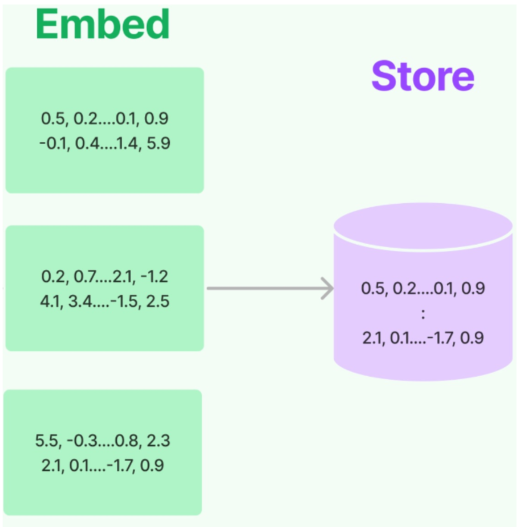

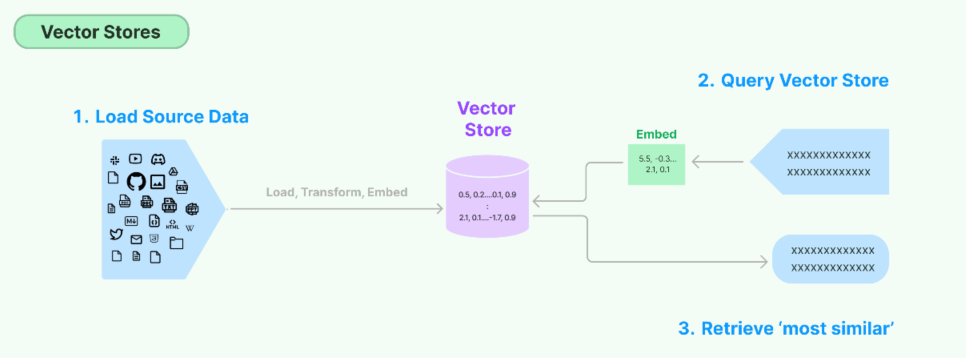

## 常用的向量数据库
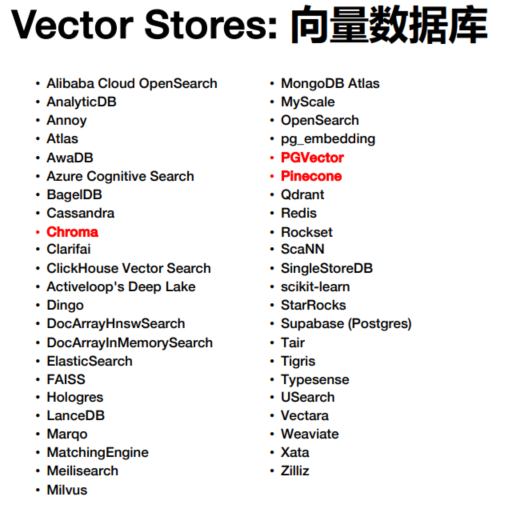

典型的介绍如下：

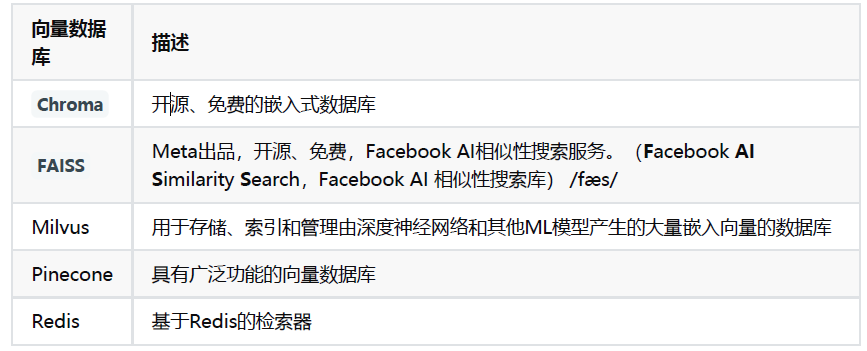

## 代码实现
使用向量数据库组件时需要同时传入包含文本块的Document类对象以及文本向量化组件，向量数据库组
件会自动完成将文本向量化的工作，并写入数据库中。

### 数据的存储

举例1：从TXT文档中加载数据，向量化后存储到Chroma数据库

In [36]:
from langchain_chroma import Chroma
from langchain_community.document_loaders import TextLoader
from langchain_text_splitters import CharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
import os
import dotenv

dotenv.load_dotenv()

os.environ['OPENAI_API_KEY'] = os.getenv("OPENAI_API_KEY")
os.environ['OPENAI_BASE_URL'] = os.getenv("OPENAI_BASE_URL")

# 步骤1：创建一个TextLoader的实例，并将指定的文档加载
loader = TextLoader(
    file_path="./asset/load/09-ai1.txt",
    encoding="utf-8",
)

docs = loader.load()

# 步骤2：创建文本拆分器，并拆分文档
text_splitter = CharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=100,
)

splitter_docs = text_splitter.split_documents(docs)

# print(len(splitter_docs))

# 步骤3：创建嵌入模型
embedding_model = OpenAIEmbeddings(model="text-embedding-ada-002")

# 步骤4：将文档及嵌入模型传入到Chroma相关的结构中，进行数据的存储
db = Chroma.from_documents(
    documents=splitter_docs,
    embedding=embedding_model,
)

1、当前的数据到底存在哪里了？

如果我们使用的`from_documents()`中没有显式的指明存储位置的话，则将当前的数据存储在内存中，并缓存起来。
如果需要指明具体的存储位置，需要设置参数`persist_directory`的值。

In [37]:
db1 = Chroma.from_documents(
    documents=splitter_docs,
    embedding=embedding_model,
    persist_directory="./asset/chroma-1",
)

2、需要明确，在向量数据库中，不仅存储了数据（或文档）的向量，而且还存储了数据（或文档）本身。

演示一下：检索的需求

In [38]:
query = "人工智能的核心技术有哪些呢？"

docs = db.similarity_search(query)

print(docs[0].page_content)

3. 人工智能的核心技术
3.1 机器学习
机器学习是人工智能的核心技术之一，通过算法使计算机从数据中学习并做出决策。常见的机器学习算法包括监督学习、无监督学习和强化学习。监督学习通过标记数据进行训练，无监督学习则从未标记数据中寻找模式，强化学习则通过与环境交互来优化决策。
3.2 深度学习
深度学习是机器学习的一个子领域，通过多层神经网络进行特征提取和模式识别。深度学习在图像识别、自然语言处理、语音识别等领域取得了显著成果。常见的深度学习模型包括卷积神经网络（CNN）、循环神经网络（RNN）和长短期记忆网络（LSTM）。
3.3 自然语言处理
自然语言处理（NLP）是人工智能的一个重要分支，致力于使计算机能够理解和生成人类语言。NLP技术广泛应用于机器翻译、情感分析、文本分类等领域。近年来，基于深度学习的NLP模型（如BERT、GPT）在语言理解任务中取得了突破性进展。
3.4 计算机视觉
计算机视觉是人工智能的另一个重要分支，致力于使计算机能够理解和处理图像和视频。计算机视觉技术广泛应用于图像识别、目标检测、人脸识别等领域。深度学习模型（如CNN）在计算机视觉任务中取得了显著成果。

4. 人工智能的应用领域
4.1 医疗健康
人工智能在医疗健康领域的应用包括疾病诊断、药物研发、个性化医疗等。通过分析医学影像和患者数据，人工智能可以帮助医生更准确地诊断疾病，提高治疗效果。
4.2 金融
人工智能在金融领域的应用包括风险评估、欺诈检测、算法交易等。通过分析市场数据和交易记录，人工智能可以帮助金融机构做出更明智的决策，提高运营效率。
4.3 教育
人工智能在教育领域的应用包括个性化学习、智能辅导、自动评分等。通过分析学生的学习数据，人工智能可以为学生提供个性化的学习建议，提高学习效果。
4.4 交通
人工智能在交通领域的应用包括自动驾驶、交通管理、智能导航等。通过分析交通数据和路况信息，人工智能可以帮助优化交通流量，提高交通安全。


举例2：操作csv文档，并向量化

In [39]:
from langchain.text_splitter import CharacterTextSplitter
from langchain_community.document_loaders import CSVLoader
from langchain_openai import OpenAIEmbeddings
from langchain_chroma import Chroma

import os
import dotenv

dotenv.load_dotenv()
os.environ['OPENAI_API_KEY'] = os.getenv("OPENAI_API_KEY")
os.environ['OPENAI_BASE_URL'] = os.getenv("OPENAI_BASE_URL")

# 获取嵌入模型
embeddings = OpenAIEmbeddings(model="text-embedding-ada-002")

# 加载文档并拆分（第1次拆分）
loader = CSVLoader("./asset/load/03-load.csv", encoding='utf-8')
pages = loader.load_and_split()
#print(len(pages))  # 4

# 文本拆分（第2次拆分）
text_spliter = CharacterTextSplitter.from_tiktoken_encoder(chunk_size=500)
docs = text_spliter.split_documents(pages)

# 向量存储
db_path = './asset/chroma-2'
db = Chroma.from_documents(docs, embeddings, persist_directory=db_path)

### 数据的检索

前置代码：

In [40]:
# 1.导入相关依赖
from langchain_chroma import Chroma
from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings

# 2.定义文档
raw_documents = [
    Document(
        page_content="葡萄是一种常见的水果，属于葡萄科葡萄属植物。它的果实呈圆形或椭圆形，颜色有绿色、紫色、红色等多种。葡萄富含维生素C和抗氧化物质，可以直接食用或酿造成葡萄酒。",
        metadata={"source": "水果", "type": "植物"}
    ),
    Document(
        page_content="白菜是十字花科蔬菜，原产于中国北方。它的叶片层层包裹形成紧密的球状，口感清脆微甜。白菜富含膳食纤维和维生素K，常用于制作泡菜、炒菜或煮汤。",
        metadata={"source": "蔬菜", "type": "植物"}
    ),
    Document(
        page_content="狗是人类最早驯化的动物之一，属于犬科。它们具有高度社会性，能理解人类情绪，常被用作宠物、导盲犬或警犬。不同品种的狗在体型、毛色和性格上有很大差异。",
        metadata={"source": "动物", "type": "哺乳动物"}
    ),
    Document(
        page_content="猫是小型肉食性哺乳动物，性格独立但也能与人类建立亲密关系。它们夜视能力极强，擅长捕猎老鼠。家猫的品种包括波斯猫、暹罗猫等，毛色和花纹多样。",
        metadata={"source": "动物", "type": "哺乳动物"}
    ),
    Document(
        page_content="人类是地球上最具智慧的生物，属于灵长目人科。现代人类（智人）拥有高度发达的大脑，创造了语言、工具和文明。人类的平均寿命约70-80年，分布在全球各地。",
        metadata={"source": "生物", "type": "灵长类"}
    ),
    Document(
        page_content="太阳是太阳系的中心恒星，直径约139万公里，主要由氢和氦组成。它通过核聚变反应产生能量，为地球提供光和热。太阳活动周期约为11年，会影响地球气候。",
        metadata={"source": "天文", "type": "恒星"}
    ),
    Document(
        page_content="长城是中国古代的军事防御工程，总长度超过2万公里。它始建于春秋战国时期，秦朝连接各段，明朝大规模重修。长城是世界文化遗产和人类建筑奇迹。",
        metadata={"source": "历史", "type": "建筑"}
    ),
    Document(
        page_content="量子力学是研究微观粒子运动规律的物理学分支。它提出了波粒二象性、测不准原理等概念，彻底改变了人类对物质世界的认知。量子计算机正是基于这一理论发展而来。",
        metadata={"source": "物理", "type": "科学"}
    ),
    Document(
        page_content="《红楼梦》是中国古典文学四大名著之一，作者曹雪芹。小说以贾、史、王、薛四大家族的兴衰为背景，描绘了贾宝玉与林黛玉的爱情悲剧，反映了封建社会的种种矛盾。",
        metadata={"source": "文学", "type": "小说"}
    ),
    Document(
        page_content="新冠病毒（SARS-CoV-2）是一种可引起呼吸道疾病的冠状病毒。它通过飞沫传播，主要症状包括发热、咳嗽、乏力。疫苗和戴口罩是有效的预防措施。",
        metadata={"source": "医学", "type": "病毒"}
    )
]
# 3. 创建嵌入模型
embedding = OpenAIEmbeddings(model="text-embedding-ada-002")

# 4.创建向量数据库
db = Chroma.from_documents(
    documents=raw_documents,
    embedding=embedding,
    persist_directory="./asset/chroma-3",
)

① 相似性检索（similarity_search）

In [ ]:
# 5. 检索示例（返回前3个最相关结果）
query = "哺乳动物"
docs = db.similarity_search(query, k=3)  # k=3表示返回3个最相关文档
print(f"查询: '{query}' 的结果:")
for i, doc in enumerate(docs, 1):
    print(f"\n结果 {i}:")
    print(f"内容: {doc.page_content}")
    print(f"元数据: {doc.metadata}")

② 支持直接对问题向量查询（similarity_search_by_vector）

In [41]:
query = "哺乳动物"
embedding_vector = embedding.embed_query(query)

docs = db.similarity_search_by_vector(embedding_vector, k=3)

print(f"查询: '{query}' 的结果:")
for i, doc in enumerate(docs, 1):
    print(f"\n结果 {i}:")
    print(f"内容: {doc.page_content}")
    print(f"元数据: {doc.metadata}")

查询: '哺乳动物' 的结果:

结果 1:
内容: 猫是小型肉食性哺乳动物，性格独立但也能与人类建立亲密关系。它们夜视能力极强，擅长捕猎老鼠。家猫的品种包括波斯猫、暹罗猫等，毛色和花纹多样。
元数据: {'source': '动物', 'type': '哺乳动物'}

结果 2:
内容: 狗是人类最早驯化的动物之一，属于犬科。它们具有高度社会性，能理解人类情绪，常被用作宠物、导盲犬或警犬。不同品种的狗在体型、毛色和性格上有很大差异。
元数据: {'type': '哺乳动物', 'source': '动物'}

结果 3:
内容: 人类是地球上最具智慧的生物，属于灵长目人科。现代人类（智人）拥有高度发达的大脑，创造了语言、工具和文明。人类的平均寿命约70-80年，分布在全球各地。
元数据: {'source': '生物', 'type': '灵长类'}


③ 相似性检索，支持过滤元数据（filter）

In [42]:
query = "哺乳动物"

docs = db.similarity_search(
    query=query,
    k=3,
    filter={"source": "动物"})

for i, doc in enumerate(docs, 1):
    print(f"\n结果 {i}:")
    print(f"内容: {doc.page_content}")
    print(f"元数据: {doc.metadata}")



结果 1:
内容: 猫是小型肉食性哺乳动物，性格独立但也能与人类建立亲密关系。它们夜视能力极强，擅长捕猎老鼠。家猫的品种包括波斯猫、暹罗猫等，毛色和花纹多样。
元数据: {'source': '动物', 'type': '哺乳动物'}

结果 2:
内容: 狗是人类最早驯化的动物之一，属于犬科。它们具有高度社会性，能理解人类情绪，常被用作宠物、导盲犬或警犬。不同品种的狗在体型、毛色和性格上有很大差异。
元数据: {'source': '动物', 'type': '哺乳动物'}


④ 通过L2距离分数进行搜索（similarity_search_with_score）

In [43]:
docs = db.similarity_search_with_score(
    "量子力学是什么?"
)
for doc, score in docs:
    print(f" [L2距离得分={score:.3f}] {doc.page_content} [{doc.metadata}]")

 [L2距离得分=0.182] 量子力学是研究微观粒子运动规律的物理学分支。它提出了波粒二象性、测不准原理等概念，彻底改变了人类对物质世界的认知。量子计算机正是基于这一理论发展而来。 [{'type': '科学', 'source': '物理'}]
 [L2距离得分=0.447] 太阳是太阳系的中心恒星，直径约139万公里，主要由氢和氦组成。它通过核聚变反应产生能量，为地球提供光和热。太阳活动周期约为11年，会影响地球气候。 [{'source': '天文', 'type': '恒星'}]
 [L2距离得分=0.463] 人类是地球上最具智慧的生物，属于灵长目人科。现代人类（智人）拥有高度发达的大脑，创造了语言、工具和文明。人类的平均寿命约70-80年，分布在全球各地。 [{'type': '灵长类', 'source': '生物'}]
 [L2距离得分=0.488] 新冠病毒（SARS-CoV-2）是一种可引起呼吸道疾病的冠状病毒。它通过飞沫传播，主要症状包括发热、咳嗽、乏力。疫苗和戴口罩是有效的预防措施。 [{'source': '医学', 'type': '病毒'}]


说明：分数值越小，检索到的文档越和问题相似。分值取值范围：[0，正无穷]

⑤ 通过余弦相似度分数进行搜索（_similarity_search_with_relevance_scores）

In [44]:
docs = db._similarity_search_with_relevance_scores(
    "量子力学是什么?"
)
for doc, score in docs:
    print(f"* [余弦相似度得分={score:.3f}] {doc.page_content} [{doc.metadata}]")

* [余弦相似度得分=0.871] 量子力学是研究微观粒子运动规律的物理学分支。它提出了波粒二象性、测不准原理等概念，彻底改变了人类对物质世界的认知。量子计算机正是基于这一理论发展而来。 [{'source': '物理', 'type': '科学'}]
* [余弦相似度得分=0.684] 太阳是太阳系的中心恒星，直径约139万公里，主要由氢和氦组成。它通过核聚变反应产生能量，为地球提供光和热。太阳活动周期约为11年，会影响地球气候。 [{'source': '天文', 'type': '恒星'}]
* [余弦相似度得分=0.672] 人类是地球上最具智慧的生物，属于灵长目人科。现代人类（智人）拥有高度发达的大脑，创造了语言、工具和文明。人类的平均寿命约70-80年，分布在全球各地。 [{'source': '生物', 'type': '灵长类'}]
* [余弦相似度得分=0.655] 新冠病毒（SARS-CoV-2）是一种可引起呼吸道疾病的冠状病毒。它通过飞沫传播，主要症状包括发热、咳嗽、乏力。疫苗和戴口罩是有效的预防措施。 [{'source': '医学', 'type': '病毒'}]


说明：分数值越接近1（上限），检索到的文档越和问题相似。

⑥ MMR（最大边际相关性，max_marginal_relevance_search）

MMR 是一种平衡`相关性` 和`多样性`的检索策略，避免返回高度相似的冗余结果。

In [ ]:
docs = db.max_marginal_relevance_search(
    query="量子力学是什么",
    lambda_mult=0.8,  # 侧重相似性
)

print("🔍 关于【量子力学是什么】的搜索结果：")
print("=" * 50)
for i, doc in enumerate(docs):
    print(f"\n📖 结果 {i + 1}:")
    print(f"📌 内容: {doc.page_content}")
    print(f"🏷️ 标签: {', '.join(f'{k}={v}' for k, v in doc.metadata.items())}")

参数说明：`lambda_mult`参数值介于 0 到 1 之间，用于确定结果之间的多样性程度，其中 0 对应最大多样性，1 对应最小多样性。默认值为 0.5。

# 检索器（或 召回器）Retrievers
## 介绍
从“向量存储组件”的代码实现5.4.2中可以看到，向量数据库本身已经包含了实现召回功能的函数方法
( similarity_search )。该函数通过计算原始查询向量与数据库中存储向量之间的相似度来实现召回。

LangChain还提供了更加复杂的召回策略，这些策略被集成在Retrievers（检索器或召回器）组件中。

Retrievers（检索器）是一种用于从大量文档中检索与给定查询相关的文档或信息片段的工具。检索器
不需要存储文档，只需要返回（或检索）文档即可。

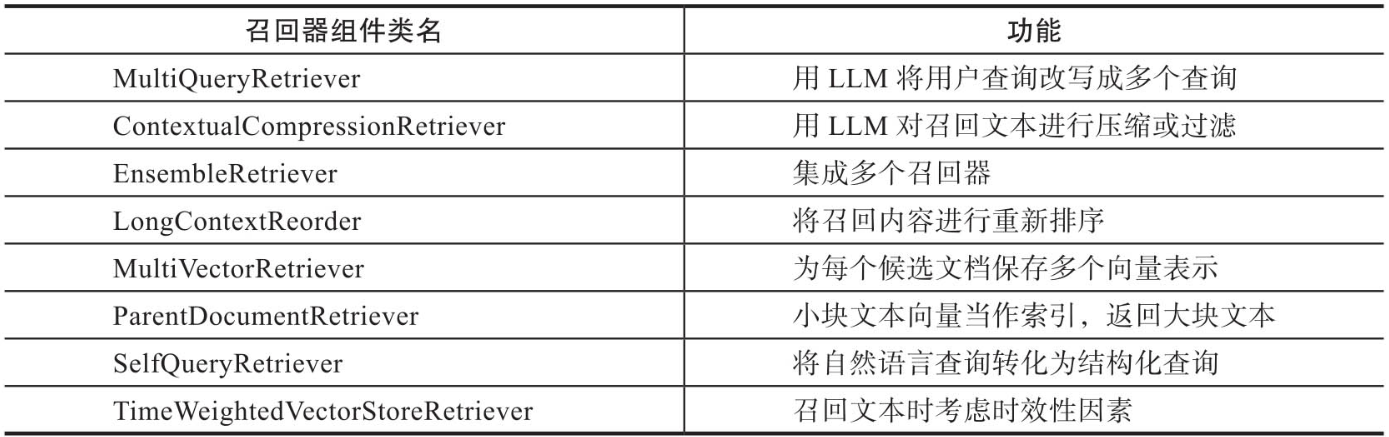

Retrievers 的执行步骤：

步骤1：将输入查询转换为向量表示。

步骤2：在向量存储中搜索与查询向量最相似的文档向量（通常使用余弦相似度或欧几里得距离等度量方法）。

步骤3：返回与查询最相关的文档或文本片段，以及它们的相似度得分。

## 代码实现
Retriever 一般和 VectorStore 配套实现，通过as_retriever() 方法获取。

In [45]:
# 1.导入相关依赖
from langchain_community.document_loaders import TextLoader
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import CharacterTextSplitter
import os
import dotenv

dotenv.load_dotenv()
# 2.定义文档加载器
loader = TextLoader(file_path='./asset/load/09-ai1.txt', encoding="utf-8")
# 3.加载文档
documents = loader.load()
# 4.定义文本切割器
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
# 5.切割文档
docs = text_splitter.split_documents(documents)
# 6.定义嵌入模型
os.environ['OPENAI_API_KEY'] = os.getenv("OPENAI_API_KEY")
os.environ['OPENAI_BASE_URL'] = os.getenv("OPENAI_BASE_URL")
embeddings = OpenAIEmbeddings(
    model="text-embedding-3-large"
)
# 7.将文档存储到向量数据库中
db = FAISS.from_documents(docs, embeddings)
# 8.从向量数据库中得到检索器
retriever = db.as_retriever()
# 9.使用检索器检索
docs = retriever.invoke("深度学习是什么？")
print(len(docs))
# 10.得到结果
for doc in docs:
    print(f"⭐{doc}")

3
⭐page_content='人工智能综述：发展、应用与未来展望

摘要
人工智能（Artificial Intelligence，AI）作为计算机科学的一个重要分支，近年来取得了突飞猛进的发展。本文综述了人工智能的发展历程、核心技术、应用领域以及未来发展趋势。通过对人工智能的定义、历史背景、主要技术（如机器学习、深度学习、自然语言处理等）的详细介绍，探讨了人工智能在医疗、金融、教育、交通等领域的应用，并分析了人工智能发展过程中面临的挑战与机遇。最后，本文对人工智能的未来发展进行了展望，提出了可能的突破方向。

1. 引言
人工智能是指通过计算机程序模拟人类智能的一门科学。自20世纪50年代诞生以来，人工智能经历了多次起伏，近年来随着计算能力的提升和大数据的普及，人工智能技术取得了显著的进展。人工智能的应用已经渗透到日常生活的方方面面，从智能手机的语音助手到自动驾驶汽车，从医疗诊断到金融分析，人工智能正在改变着人类社会的运行方式。

2. 人工智能的发展历程
2.1 早期发展
人工智能的概念最早可以追溯到20世纪50年代。1956年，达特茅斯会议（Dartmouth Conference）被认为是人工智能研究的正式开端。在随后的几十年里，人工智能研究经历了多次高潮与低谷。早期的研究主要集中在符号逻辑和专家系统上，但由于计算能力的限制和算法的不足，进展缓慢。
2.2 机器学习的兴起
20世纪90年代，随着统计学习方法的引入，机器学习逐渐成为人工智能研究的主流。支持向量机（SVM）、决策树、随机森林等算法在分类和回归任务中取得了良好的效果。这一时期，机器学习开始应用于数据挖掘、模式识别等领域。
2.3 深度学习的突破
2012年，深度学习在图像识别领域取得了突破性进展，标志着人工智能进入了一个新的阶段。深度学习通过多层神经网络模拟人脑的工作方式，能够自动提取特征并进行复杂的模式识别。卷积神经网络（CNN）、循环神经网络（RNN）和长短期记忆网络（LSTM）等深度学习模型在图像处理、自然语言处理、语音识别等领域取得了显著成果。' metadata={'source': './asset/load/09-ai1.txt'}
⭐page_content='3. 人工智能的核心技术
3.1 机器学习
机器学习是人工智能的核心技术之一，通过算法使计算机从数据中学习并做出决策。

## 使用相关检索策略

前置代码：

In [46]:
# 1.导入相关依赖
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_core.documents import Document

# 2.定义文档
document_1 = Document(
    page_content="经济复苏：美国经济正在从疫情中强劲复苏，失业率降至历史低点。！",
)
document_2 = Document(
    page_content="基础设施：政府将投资1万亿美元用于修复道路、桥梁和宽带网络。",
)
document_3 = Document(
    page_content="气候变化：承诺到2030年将温室气体排放量减少50%。",
)
document_4 = Document(
    page_content=" 医疗保健：降低处方药价格，扩大医疗保险覆盖范围。",
)
document_5 = Document(
    page_content="教育：提供免费的社区大学教育。。",
)
document_6 = Document(
    page_content="科技：增加对半导体产业的投资以减少对外国供应链的依赖。。",
)
document_7 = Document(
    page_content="外交政策：继续支持乌克兰对抗俄罗斯的侵略。",
)
document_8 = Document(
    page_content="枪支管制：呼吁国会通过更严格的枪支管制法律。",
)
document_9 = Document(
    page_content="移民改革：提出全面的移民改革方案。",
)
document_10 = Document(
    page_content="社会正义：承诺解决系统性种族歧视问题。",
)
documents = [
    document_1,
    document_2,
    document_3,
    document_4,
    document_5,
    document_6,
    document_7,
    document_8,
    document_9,
    document_10,
]

# 3.创建向量存储
embeddings = OpenAIEmbeddings(
    model="text-embedding-3-large"
)

# 4.将文档向量化，添加到向量数据库索引中，得到向量数据库对象
db = FAISS.from_documents(documents, embeddings)

① 默认检索器使用相似性搜索

In [47]:
# 获取检索器
retriever = db.as_retriever(search_kwargs={"k": 3}) #这里设置返回的文档数

docs = retriever.invoke("经济政策")

for i, doc in enumerate(docs):
    print(f"\n结果 {i+1}:\n{doc.page_content}\n")



结果 1:
经济复苏：美国经济正在从疫情中强劲复苏，失业率降至历史低点。！


结果 2:
科技：增加对半导体产业的投资以减少对外国供应链的依赖。。


结果 3:
外交政策：继续支持乌克兰对抗俄罗斯的侵略。



② 分数阈值查询

In [48]:
retriever = db.as_retriever(
    search_type="similarity_score_threshold",
    search_kwargs={"score_threshold": 0.1}
)
docs = retriever.invoke("经济政策")

for doc in docs:
    print(f"📌 内容: {doc.page_content}")

📌 内容: 经济复苏：美国经济正在从疫情中强劲复苏，失业率降至历史低点。！


③ MMR搜索

In [49]:
retriever = db.as_retriever(
    search_type="mmr",
    search_kwargs={"fetch_k":2}
)

docs = retriever.invoke("经济政策")

print(len(docs))

for  doc  in  docs:
    print(f"📌 内容: {doc.page_content}")

2
📌 内容: 经济复苏：美国经济正在从疫情中强劲复苏，失业率降至历史低点。！
📌 内容: 科技：增加对半导体产业的投资以减少对外国供应链的依赖。。


## 结合大模型的使用

举例1：不使用RAG技术

In [50]:
from langchain_openai import ChatOpenAI
import os
import dotenv
dotenv.load_dotenv()

os.environ['OPENAI_API_KEY'] = os.getenv("OPENAI_API_KEY")
os.environ['OPENAI_BASE_URL'] = os.getenv("OPENAI_BASE_URL")

# 创建大模型实例
llm = ChatOpenAI(model="gpt-4o-mini")

# 调用
response = llm.invoke("北京有什么著名的建筑？")
print(response.content)

北京有许多著名的建筑，以下是一些代表性的例子：

1. **故宫**：明清两代的皇家宫殿，是中国古代宫殿建筑的杰出代表，现为博物馆，收藏了大量珍贵文物。

2. **天安门**：位于天安门广场的标志性建筑，是中国的象征之一，周围有人民英雄纪念碑和毛主席纪念堂。

3. **长城**：虽然长城是一项广泛的工程，但北京周边的八达岭、慕田峪等段落尤其著名，吸引了大量游客。

4. **颐和园**：清朝的皇家园林，以其山水景观和古典建筑闻名，特别是昆明湖和万寿山。

5. **天坛**：明清两代皇帝祭天的场所，以其独特的圆形建筑和和谐的园林设计而闻名。

6. **北京鸟巢**（国家体育场）：为2008年夏季奥运会而建的现代建筑，以其独特的外观和结构而受到国际赞誉。

7. **北京大兴国际机场**：开通于2019年，是世界上最大的机场航站楼之一，现代设计与高科技设施相结合。

8. **后海与胡同**：后海地区有着丰富的历史和文化，小巷子（胡同）体现了传统北京的生活方式。

这些建筑不仅展示了北京的历史和文化，还反映了现代建筑的成就。


举例2：通过FAISS构建一个可搜索的向量索引数据库，并结合RAG技术让LLM去回答问题。

In [53]:
# 1. 导入所有需要的包
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI,OpenAIEmbeddings
from langchain_community.document_loaders import TextLoader
from langchain_text_splitters import CharacterTextSplitter
from langchain_community.vectorstores import FAISS
import os
import dotenv

dotenv.load_dotenv()

# 2. 创建自定义提示词模板
prompt_template = """请使用以下提供的文本内容来回答问题。仅使用提供的文本信息，如果文本中没有相关信息，请回答"抱歉，提供的文本中没有这个信息"。

文本内容：
{context}

问题：{question}

回答：
"
"""

prompt = PromptTemplate.from_template(prompt_template)

# 3. 初始化模型
os.environ['OPENAI_API_KEY'] = os.getenv("OPENAI_API_KEY")
os.environ['OPENAI_BASE_URL'] = os.getenv("OPENAI_BASE_URL")
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0,
)

embedding_model = OpenAIEmbeddings(model="text-embedding-3-large")

# 4. 加载文档
loader = TextLoader("./asset/load/10-test_doc.txt", encoding='utf-8')
documents = loader.load()

# 5. 分割文档
text_splitter = CharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=100,
)
texts = text_splitter.split_documents(documents)

#print(f"文档个数:{len(texts)}")

# 6. 创建向量存储
vectorstore = FAISS.from_documents(
    documents=texts,
    embedding=embedding_model
)

# 7.获取检索器
retriever = vectorstore.as_retriever()

docs = retriever.invoke("北京有什么著名的建筑？")

# 8. 创建Runnable链
chain = prompt | llm

# 9. 提问
result = chain.invoke(input={"question":"北京有什么著名的建筑？","context":docs})
print("\n回答:", result.content)


回答: 北京有以下著名的建筑：

1. 故宫 - 又称紫禁城，是明清两代的皇家宫殿，位于北京市中心，1987年被列为世界文化遗产。
2. 天安门 - 位于故宫南端，是北京的标志性建筑之一，天安门广场是世界上最大的城市广场。
3. 颐和园 - 清朝时期的皇家园林，1998年被列入世界文化遗产。
4. 天坛 - 明清两代皇帝祭天、祈谷的场所，1998年被列为世界文化遗产。
5. 长城（八达岭段） - 最著名的北京段，被誉为"世界第八大奇迹"。
6. 国家体育场（鸟巢） - 2008年奥运会主体育场，以独特的钢结构设计成为现代北京的地标。
7. 中央电视台总部大楼 - 俗称"大裤衩"，是现代北京最具争议的建筑之一。
8. 国家大剧院 - 位于天安门广场西侧，因其蛋壳造型被称为"巨蛋"。
9. 北京大兴国际机场 - 2019年投入使用的超大型国际航空枢纽，被誉为"新世界七大奇迹"之一。
10. 鼓楼和钟楼 - 位于北京中轴线北端，是元明清三代的报时中心。
